The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The number of parameters to be fit is 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 291279.346563515
            Iterations: 31
            Function evaluations: 241
            Gradient evaluations: 31
[0.89989243 0.14331159 0.03798742]


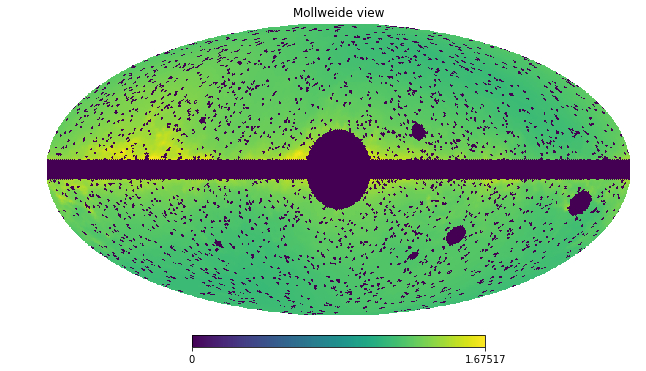

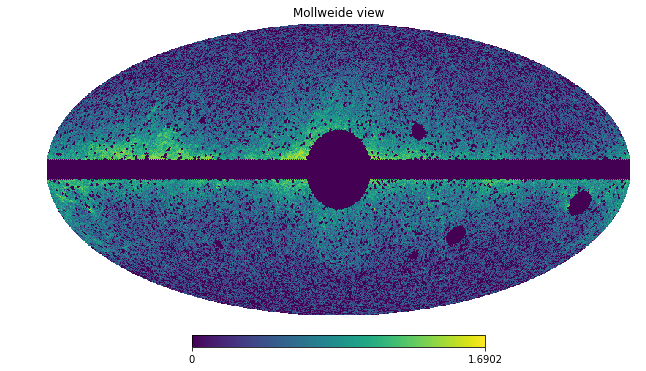

In [19]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt

from __future__ import division
from __future__ import print_function


# Tigress dirs
import os, sys
import copy

import argparse
import numpy as np
import iminuit
from iminuit import Minuit, describe, Struct
from scipy.interpolate import interp1d
from scipy.integrate import quad
from scipy.optimize import minimize
from mpi4py import MPI
# NPTFit modules
from NPTFit import nptfit # module for performing scan
from NPTFit import create_mask as cm # module for creating the mask
from NPTFit import psf_correction as pc # module for determining the PSF correction
from NPTFit import dnds_analysis
import pandas as pd
import healpy as hp

# My Modules
from Recxsec_modules_NP import makeMockData, getNPTFitLL, SCDParams_Flux2Counts

ebins = 2*np.logspace(-1,3,41)[0:41]
my_iebins = [10, 15]

exposure_ebins= []
dif_ebins= []
iso_ebins= []
psc_ebins = []
fermi_data_ebins = []

for ib, b in enumerate(my_iebins[:-1]):
    fermi_exposure = np.zeros(hp.nside2npix(128))
    dif = np.zeros(len(fermi_exposure))
    iso = np.zeros(len(fermi_exposure))
    psc = np.zeros(len(fermi_exposure))
    data = np.zeros(len(fermi_exposure))
    n = 0
    for bin_ind in range(b, my_iebins[ib+1]):
        n+=1
        fermi_exposure += np.load('/tigress/somalwar/Subhaloes/Subhalos/EnergyBins/maps/exposure'+str(bin_ind)+'.npy')
        dif += np.load('/tigress/somalwar/Subhaloes/Subhalos/EnergyBins/maps/dif'+str(bin_ind)+'.npy')
        iso += np.load('/tigress/somalwar/Subhaloes/Subhalos/EnergyBins/maps/iso'+str(bin_ind)+'.npy')
        psc += np.load('/tigress/somalwar/Subhaloes/Subhalos/EnergyBins/maps/psc'+str(bin_ind)+'.npy')
        data += np.load('/tigress/somalwar/Subhaloes/Subhalos/EnergyBins/maps/data'+str(bin_ind)+'.npy')
    fermi_exposure = fermi_exposure / n
    dif_ebins.append(dif)
    iso_ebins.append(iso)
    psc_ebins.append(psc)
    fermi_data_ebins.append(data.astype(np.int32))
    exposure_ebins.append(fermi_exposure)

pscmask = np.array(np.load('/tigress/somalwar/Subhaloes/Subhalos/fermi_data/fermidata_pscmask.npy'), dtype=bool)
mask = cm.make_mask_total(band_mask = True, band_mask_range = 5, mask_ring = True, inner = 20, outer = 180, custom_mask = pscmask)

data_ebins = []
for ib, b in enumerate(my_iebins[:-1]):
    n_bkg = nptfit.NPTF(tag='norm')
    n_bkg.load_data(fermi_data_ebins[ib].copy(), exposure_ebins[ib].copy())
    n_bkg.load_mask(mask)

    n_bkg.add_template(dif_ebins[ib].copy(), 'dif')
    n_bkg.add_template(iso_ebins[ib].copy(), 'iso')
    n_bkg.add_template(psc_ebins[ib].copy(), 'psc')

    n_bkg.add_poiss_model('dif', '$A_\mathrm{dif}$', [0,20], False)
    n_bkg.add_poiss_model('iso', '$A_\mathrm{iso}$', [0,20], False)
    n_bkg.add_poiss_model('psc', '$A_\mathrm{psc}$', [0,20], False)

    n_bkg.configure_for_scan()

    bkg_min = minimize( lambda args: -n_bkg.ll([*args]), 
                        [ 0.89, 5, 0.03795109 ], method="SLSQP", bounds = [ [0,10], [0,10], [0,10] ], options={'ftol':1e-15, 'eps':1e-10, 'maxiter':5000, 'disp':True} )
    print(bkg_min.x)
    fake_data = bkg_min.x[0]*dif_ebins[ib] + 3*iso_ebins[ib] + bkg_min.x[2]*psc_ebins[ib]
    fake_data[mask] = 0
    fermi_data_ebins[ib][mask] = 0
    hp.mollview(np.log10(1+fake_data))
    hp.mollview(np.log10(1+fermi_data_ebins[ib]))